# **Big Data Machine Learning**

| Nama                    | NRP         |
|-------------------------|-------------|
| Nathan Kho Pancras      | 5027231002  |
| Michael Kenneth Salim   | 5027231008  |
| Fico Simhanandi         | 5027231030  |


## **Detail Data**

| Column Name           | Description                                                                 |
|-----------------------|-----------------------------------------------------------------------------|
| movie_id              | Unique identifier for each movie.                                           |
| title                 | Title of the movie.                                                         |
| vote_average          | Average rating of the movie (e.g., from 0 to 10).                           |
| vote_count            | Total number of votes the movie has received.                              |
| status                | Status of the movie (e.g., "Released", "Planned").                          |
| release_date          | Release date of the movie.                                                  |
| revenue               | Total revenue generated by the movie.                                      |
| adult                 | Indicates whether the movie is for adults (true/false).                     |
| budget                | Budget for the movie production.                                            |
| imdb_id               | Unique identifier for the movie on IMDb.                                    |
| original_language     | Language in which the movie was originally produced.                        |
| original_title        | Original title of the movie (if different from the main title).             |
| overview              | Brief summary or description of the movie.                                  |
| popularity            | Popularity score of the movie, often based on various factors.              |
| genres                | Comma-separated list of genres associated with the movie.                   |
| production_companies  | Comma-separated list of companies that produced the movie.                  |
| production_countries  | Comma-separated list of countries where the movie was produced.             |
| spoken_languages      | Comma-separated list of languages spoken in the movie.                      |


## **Import Library**

In [141]:
import kagglehub
import pandas as pd
import os
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorIndexer, MinMaxScaler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [122]:
path = kagglehub.dataset_download("mohammedalsubaie/movies")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/movies


### **Inisiasi Spark Session**

In [123]:
spark = SparkSession.builder.appName("Movies").getOrCreate()

In [124]:
spark

### **Membaca isi data**

In [125]:
df = spark.read.csv(f"{path}/Movies.csv", header=True, inferSchema=True)
pandas_df = pd.read_csv(f"{path}/Movies.csv")

In [126]:
df.printSchema()

root
 |-- movie_id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: string (nullable = true)
 |-- vote_count: string (nullable = true)
 |-- status: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: string (nullable = true)
 |-- adult: string (nullable = true)
 |-- budget: string (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- spoken_languages: string (nullable = true)



In [127]:
df.show(5)

+--------+---------------+------------+----------+--------+------------+----------+-----+---------+---------+-----------------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|movie_id|          title|vote_average|vote_count|  status|release_date|   revenue|adult|   budget|  imdb_id|original_language| original_title|            overview|          popularity|              genres|production_companies|production_countries|    spoken_languages|
+--------+---------------+------------+----------+--------+------------+----------+-----+---------+---------+-----------------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 4520010|      Inception|       8.364|     34495|Released|   7/15/2010| 825532764|FALSE|160000000|tt1375666|               en|      Inception|"Cobb, a skilled ...| the implantation...|     

In [128]:
pandas_df.shape

(1048575, 18)

In [129]:
pandas_df.isnull().sum()

,0
movie_id,0
title,13
vote_average,0
vote_count,0
status,0
release_date,149422
revenue,0
adult,0
budget,0
imdb_id,471584


In [130]:
df = df.drop('movie_id', 'genres', 'overview', 'imdb_id', 'production_companies', 'production_countries', 'spoken_languages', 'release_date')

In [131]:
panda_df = pandas_df.drop(['movie_id', 'genres', 'overview', 'imdb_id', 'production_companies', 'production_countries', 'spoken_languages', 'release_date'], axis=1, inplace=True)

In [132]:
df.printSchema()

root
 |-- title: string (nullable = true)
 |-- vote_average: string (nullable = true)
 |-- vote_count: string (nullable = true)
 |-- status: string (nullable = true)
 |-- revenue: string (nullable = true)
 |-- adult: string (nullable = true)
 |-- budget: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- popularity: string (nullable = true)



In [133]:
pandas_df.isnull().sum()

,0
title,13
vote_average,0
vote_count,0
status,0
revenue,0
adult,0
budget,0
original_language,0
original_title,13
popularity,0


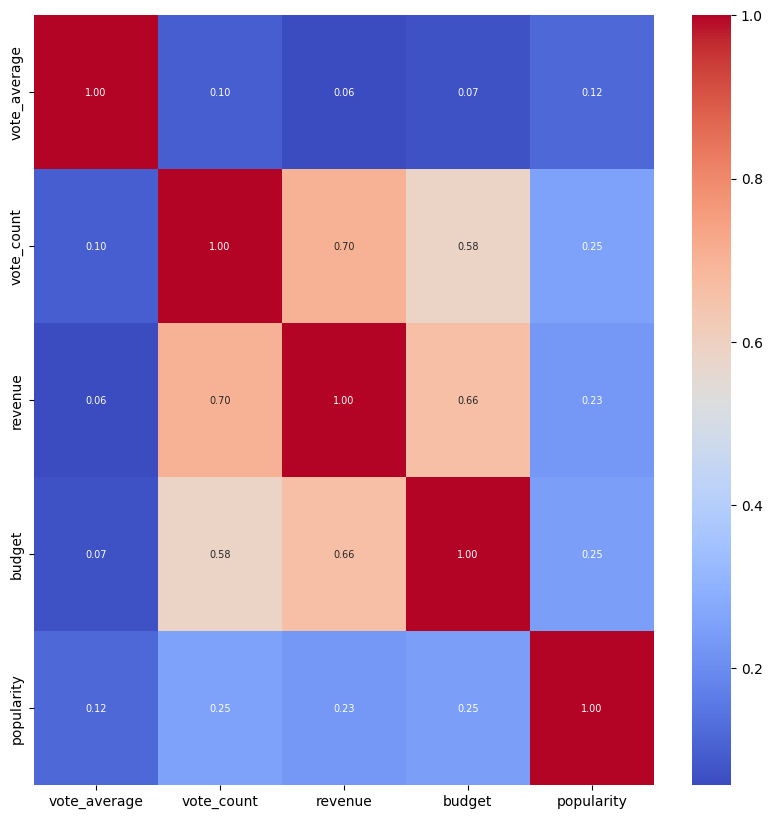

In [134]:
numerical_df = pandas_df.select_dtypes(include=['number'])
correlation_matrix = numerical_df.corr()

plt.figure(figsize = (10,10))
sns.heatmap(correlation_matrix, cmap = 'coolwarm', annot=True, fmt=".2f", annot_kws={"size": 7})
plt.show()

In [135]:
pandas_df.head()

,title,vote_average,vote_count,status,revenue,adult,budget,original_language,original_title,popularity
0,Inception,8.364,34495,Released,825532764,False,160000000,en,Inception,83.952
1,Interstellar,8.417,32571,Released,701729206,False,165000000,en,Interstellar,140.241
2,The Dark Knight,8.512,30619,Released,1004558444,False,185000000,en,The Dark Knight,130.643
3,Avatar,7.573,29815,Released,2923706026,False,237000000,en,Avatar,79.932
4,The Avengers,7.710,29166,Released,1518815515,False,220000000,en,The Avengers,98.082


In [120]:
df = df.withColumn("vote_average", df["vote_average"].cast("double"))
df = df.withColumn("vote_count", df["vote_count"].cast("int"))
df = df.withColumn("revenue", df["revenue"].cast("double"))
df = df.withColumn("budget", df["budget"].cast("double"))
df = df.withColumn("popularity", df["popularity"].cast("double"))

df = df.na.drop(subset=["vote_average", "vote_count", "revenue", "budget", "popularity"])

numerical_cols = ["vote_average", "vote_count", "revenue", "budget", "popularity"]
print("Numerical columns:", numerical_cols)

assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features_unscaled", handleInvalid="skip")
df_vector = assembler.transform(df)

scaler = StandardScaler(inputCol="features_unscaled", outputCol="features_scaled", withMean=True, withStd=True)
scaler_model = scaler.fit(df_vector)
df_scaled = scaler_model.transform(df_vector)

df_model = df_scaled.select("features_scaled", "vote_average")

Numerical columns: ['vote_average', 'vote_count', 'revenue', 'budget', 'popularity']


In [136]:
df_model.show()

+--------------------+------------+
|     features_scaled|vote_average|
+--------------------+------------+
|[2.04400000422010...|         8.0|
|[2.04400000422010...|         8.0|
|[1.70755083896233...|         7.0|
|[1.70755083896233...|         7.0|
|[1.70755083896233...|         7.0|
|[2.04400000422010...|         8.0|
|[1.70755083896233...|         7.0|
|[2.04400000422010...|         8.0|
|[2.04400000422010...|         8.0|
|[1.70755083896233...|         7.0|
|[1.70755083896233...|         7.0|
|[2.04400000422010...|         8.0|
|[2.04400000422010...|         8.0|
|[2.04400000422010...|         8.0|
|[2.04400000422010...|         8.0|
|[1.70755083896233...|         7.0|
|[2.04400000422010...|         8.0|
|[2.04400000422010...|         8.0|
|[2.04400000422010...|         8.0|
|[2.04400000422010...|         8.0|
+--------------------+------------+
only showing top 20 rows



In [137]:
train_data, test_data = df_model.randomSplit([0.8, 0.2], seed = 12345)

In [138]:
train_data.show(5)

+--------------------+------------+
|     features_scaled|vote_average|
+--------------------+------------+
|[-0.6475933178421...|         0.0|
|[-0.6475933178421...|         0.0|
|[-0.6475933178421...|         0.0|
|[-0.6475933178421...|         0.0|
|[-0.6475933178421...|         0.0|
+--------------------+------------+
only showing top 5 rows



### **Creating the Model**

In [142]:
lr = LinearRegression(labelCol="vote_average", featuresCol="features_scaled")
lr_model = lr.fit(train_data)
lr_pred = lr_model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="vote_average", predictionCol="prediction", metricName="accuracy")
lr_acc = evaluator.evaluate(lr_pred)

print("Random Forest Classifier Accuracy:", lr_acc)

Random Forest Classifier Accuracy: 0.0


In [ ]:
spark.stop()